
# **Include any disclaimers about the use of AI and cite the parts of the code that AI have been used for.**

In [6]:
import sys
if not sys.version.startswith("3.12"):
    raise RuntimeError("This notebook requires Python 3.12")

#%pip install numpy pandas matplotlib seaborn scikit-learn torch platform psutil getpass

# Hardware and user spercifications

import platform
import psutil
import getpass

# --- Setup: Imports ---
import os, seaborn, sklearn, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle
from sklearn.datasets import load_breast_cancer

#CODE HERE (optional): import any module needed from sklearn package

def print_system_info():
    print("="*60)
    print("SYSTEM INFORMATION")
    print("="*60)

    # OS and hardware
    print(f"Operating System : {platform.system()} {platform.release()}")
    print(f"Processor        : {platform.processor()}")
    print(f"CPU Cores        : {psutil.cpu_count(logical=True)}")
    print(f"RAM              : {round(psutil.virtual_memory().total / (1024**3), 2)} GB")

    # User
    print(f"PC Username      : {getpass.getuser()}")

    # Python and environment
    print(f"Python Version   : {platform.python_version()}")
    print(f"Working Dir      : {os.getcwd()}")

    # GPU (if PyTorch is installed)
    if torch.cuda.is_available():
        print(f"GPU Device       : {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version     : {torch.version.cuda}")
    else:
        print("GPU Device       : None (CPU mode)")

    print("="*60)
    print()

print_system_info()

# Set a random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

SYSTEM INFORMATION
Operating System : Windows 11
Processor        : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU Cores        : 8
RAM              : 31.82 GB
PC Username      : Mahad
Python Version   : 3.12.0
Working Dir      : c:\Users\Mahad\github\4AL3\assignments\A3
GPU Device       : NVIDIA GeForce RTX 4070 SUPER
CUDA Version     : 11.8



Here, we load, split, scale the data. Then we convert them to PyTorch Tensors.

In [66]:
# --- Data Loading and Preprocessing ---

# CODE HERE: Load the dataset
breast_cancer_data = load_breast_cancer()
X = breast_cancer_data.data
y = breast_cancer_data.target

# CODE HERE: Split the data (80% train, 20% validation). Set random_state=random_seed.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)

# CODE HERE: Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# CODE HERE: Convert to PyTorch Tensors

X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

print(f"Training features shape: {X_train_t.shape}")
print(f"Training labels shape: {y_train_t.shape}")
print(f"Validation features shape: {X_val_t.shape}")
print(f"Validation labels shape: {y_val_t.shape}")


Training features shape: torch.Size([455, 30])
Training labels shape: torch.Size([455, 1])
Validation features shape: torch.Size([114, 30])
Validation labels shape: torch.Size([114, 1])


Next, we define the Neural Network (NN).

In [67]:
# --- Model Definition ---

# CODE HERE: define the asked NN here
class FeedForwardNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return x

input_features = X_train_t.shape[1]
print(f"Model will accept {input_features} input features.")
print("--- 3. Model Class Defined ---")

Model will accept 30 input features.
--- 3. Model Class Defined ---


Part 1:

In [68]:
def calculate_full_loss(model, criterion, X, y):
    """Helper function to calculate loss over an entire dataset."""
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        outputs = model(X)
        loss = criterion(outputs, y)
    model.train() # Set model back to train mode
    return loss.item()

def stochastic_gradient_descent(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                                max_iterations, check_every, patience, threshold):

    #CODE HERE: fill function. Use calculate_full_loss function for loss.

    n = X_train.shape[0]

    iterations, train_losses, val_losses = [], [], []
    stochastic_losses = []
    best_val = float('inf')
    best_model_state = None
    no_improve = 0
    stop_iteration = max_iterations  

    model.train()
    for it in range(1, max_iterations + 1):
        i = torch.randint(0, n, (1,)).item()
        xb, yb = X_train[i:i+1], y_train[i:i+1]

        optimizer.zero_grad()
        logits = model(xb)                
        loss = criterion(logits, yb)       
        loss.backward()
        optimizer.step()

        stochastic_losses.append(loss.item())

        if it % check_every == 0 or it == 1:
            tr_loss = calculate_full_loss(model, criterion, X_train, y_train)
            va_loss = calculate_full_loss(model, criterion, X_val,   y_val)

            iterations.append(it)
            train_losses.append(tr_loss)
            val_losses.append(va_loss)

            # improvement on validation?
            if (best_val - va_loss) >= threshold:
                best_val = va_loss
                best_model_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    stop_iteration = it
                    break  # stop as soon as patience is exceeded
    

    return train_losses, val_losses, iterations, stop_iteration, best_model_state, stochastic_losses



Training and plot:

Plotting Part 1 results...


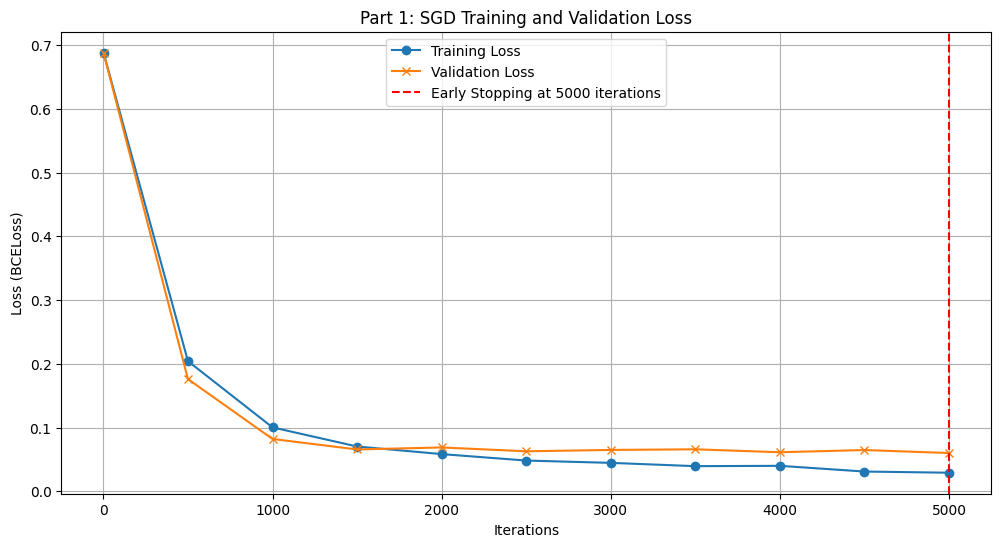


Accuracy of Early-Stopped Model on Validation Set: 97.37%


In [69]:
# --- Hyperparameters for Part 1 ---
LEARNING_RATE = 1e-2
MAX_ITERATIONS = 5000
CHECK_EVERY = MAX_ITERATIONS // 10
PATIENCE = 3
THRESHOLD = 1e-4

# --- Model Initialization ---

model_sgd = FeedForwardNet(input_size=input_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_sgd.parameters(), lr=LEARNING_RATE)

# --- Run Training ---

train_losses_sgd, val_losses_sgd, iterations_sgd, stop_iter, best_state, stochastic_losses = stochastic_gradient_descent(
    model_sgd, criterion, optimizer,
    X_train_t, y_train_t, X_val_t, y_val_t,
    MAX_ITERATIONS, CHECK_EVERY, PATIENCE, THRESHOLD
)

if best_state is not None:
    model_sgd.load_state_dict(best_state)

# --- Plotting Results ---
print("Plotting Part 1 results...")
plt.figure(figsize=(12, 6))
plt.plot(iterations_sgd, train_losses_sgd, label='Training Loss', marker='o')
plt.plot(iterations_sgd, val_losses_sgd, label='Validation Loss', marker='x')
plt.axvline(x=stop_iter, color='red', linestyle='--',
            label=f'Early Stopping at {stop_iter} iterations')
plt.title('Part 1: SGD Training and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (BCELoss)')
plt.legend()
plt.grid(True)
plt.show()

# --- Final Accuracy ---

#CODE HERE

with torch.no_grad():

    # run validation data trhough the model -> output = logits
    # use torch.sigmoid to convert logits to probabilities
    probs = torch.sigmoid(model_sgd(X_val_t)).numpy().ravel() 
    # turn probabilities to binary predictions
    preds = (probs >= 0.5).astype(int)
    # compare predictions to the true labels to get accuracy
    accuracy = accuracy_score(y_val, preds)

    print(f"\nAccuracy of Early-Stopped Model on Validation Set: {accuracy * 100:.2f}%")


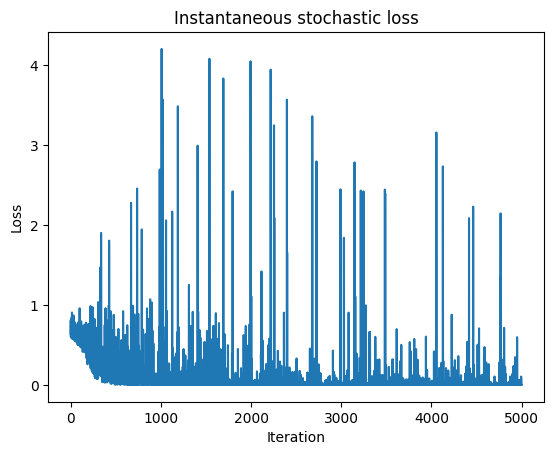

In [70]:
plt.plot(stochastic_losses)
plt.title("Instantaneous stochastic loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Part 2:

In [71]:
def train_with_minibatch(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                         num_iterations, batch_size, check_every):

    n = X_train.shape[0]
    iterations, train_losses, val_losses = [], [], []
    batch_losses = []
    it = 0
    model.train()

    while it < num_iterations:
        # create a random minibatch
        perm = torch.randperm(n)
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb, yb = X_train[idx], y_train[idx]

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)   
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            it += 1

            if it % check_every == 0 or it == 1:
                tr = calculate_full_loss(model, criterion, X_train, y_train)
                va = calculate_full_loss(model, criterion, X_val,   y_val)
                iterations.append(it)
                train_losses.append(tr)
                val_losses.append(va)
            if it >= num_iterations:
                break

    return train_losses, val_losses, iterations, model, batch_losses # Return the final model


Training and plot:

Plotting Part 2 comparison...


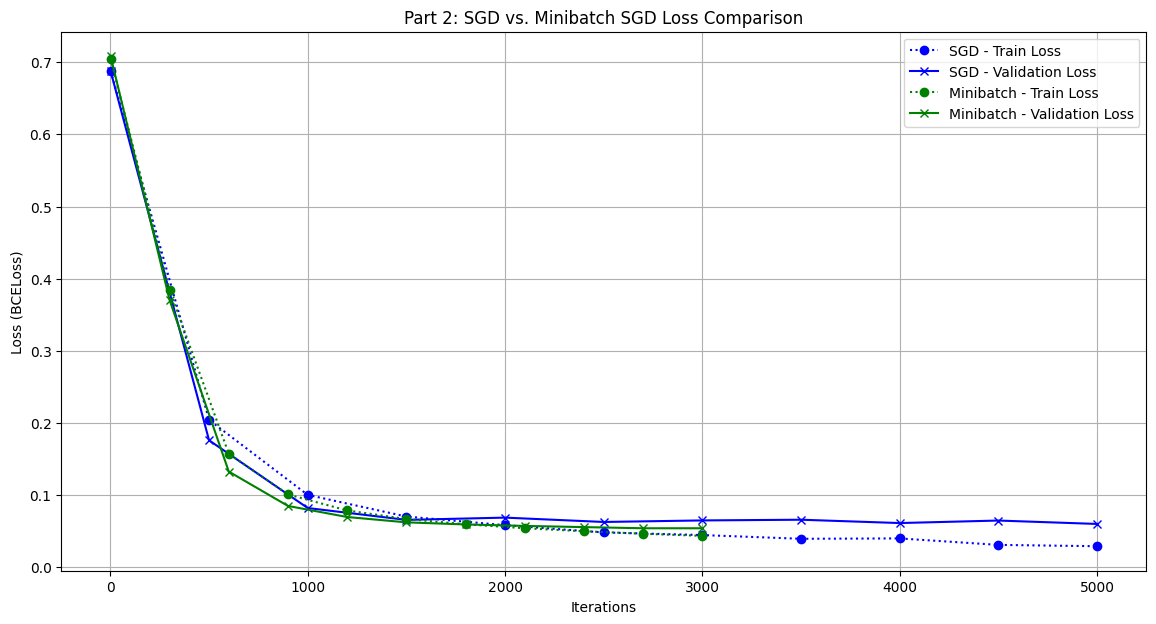

In [72]:
# --- Hyperparameters for Part 2 ---
LEARNING_RATE_MB = 1e-2
NUM_ITERATIONS_MB = 3000
BATCH_SIZE = 64
CHECK_EVERY_MB = NUM_ITERATIONS_MB // 10

# --- Model Initialization ---

model_mb = FeedForwardNet(input_size=input_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_mb.parameters(), lr=LEARNING_RATE_MB)

# --- Run Minibatch Training ---

# --- Run Minibatch Training ---
train_losses_mb, val_losses_mb, iterations_mb, model_mb, batch_losses = train_with_minibatch(
    model_mb, criterion, optimizer,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS_MB, BATCH_SIZE, CHECK_EVERY_MB
)


# --- Plotting Comparison ---
print("Plotting Part 2 comparison...")
plt.figure(figsize=(14, 7))

# SGD (Part 1)
plt.plot(iterations_sgd, train_losses_sgd, label='SGD - Train Loss', linestyle=':', color='blue', marker='o')
plt.plot(iterations_sgd, val_losses_sgd, label='SGD - Validation Loss', linestyle='-', color='blue', marker='x')

# Minibatch (Part 2)
plt.plot(iterations_mb, train_losses_mb, label='Minibatch - Train Loss', linestyle=':', color='green', marker='o')
plt.plot(iterations_mb, val_losses_mb, label='Minibatch - Validation Loss', linestyle='-', color='green', marker='x')

plt.title('Part 2: SGD vs. Minibatch SGD Loss Comparison')
plt.xlabel('Iterations')
plt.ylabel('Loss (BCELoss)')
plt.legend()
plt.grid(True)
plt.show()



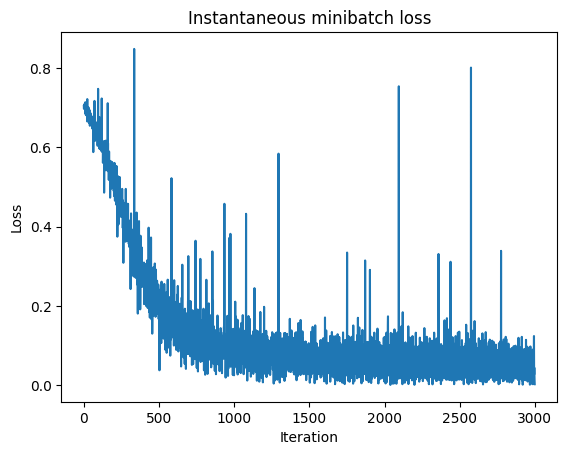

In [73]:
plt.plot(batch_losses)
plt.title("Instantaneous minibatch loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Performance evaluation:

In [74]:
# --- Performance Metrics Comparison ---

def get_metrics(model, X_val, y_val):
    """Helper function to get accuracy, precision, and recall."""
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_val)
        y_pred = (y_pred_prob > 0.5).int().numpy() # Convert to numpy
        y_true = y_val.numpy()

        acc = accuracy_score(y_true, y_pred)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
    return acc, pre, rec

# Get metrics for Part 1 (Early-Stopped SGD Model)

acc_sgd, pre_sgd, rec_sgd = get_metrics(model_sgd, X_val_t, y_val_t)

# Get metrics for Part 2 (Final Minibatch Model)

acc_mb, pre_mb, rec_mb = get_metrics(model_mb, X_val_t, y_val_t)

# --- Show Results in a Table ---
results = {
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Part 1: Early-Stopped SGD': [f"{acc_sgd:.4f}", f"{pre_sgd:.4f}", f"{rec_sgd:.4f}"],
    'Part 2: Minibatch SGD': [f"{acc_mb:.4f}", f"{pre_mb:.4f}", f"{rec_mb:.4f}"]
}

results_df = pd.DataFrame(results)
print("\n--- Final Performance Metrics on Validation Set ---")

from IPython.display import display
display(results_df)



--- Final Performance Metrics on Validation Set ---


,Metric,Part 1: Early-Stopped SGD,Part 2: Minibatch SGD
0,Accuracy,0.9649,0.9912
1,Precision,0.9855,0.9861
2,Recall,0.9577,1.0000


# EXPLAIN HERE: Based on your experiments, answer the following questions:

1) How does early stopping affect the training and validation loss curves compared to training for all 5000 iterations?
2) How does minibatch SGD affect the smoothness of loss curves compared to true SGD with batch_size=1?


***Part 3***

In [ ]:
class FeedForwardNetWithDropout(nn.Module):
    """
    TODO: Complete this neural network class to include dropout layers.

    The dropout_rate parameter should control the dropout probability.
    When dropout_rate=0.0, no dropout is applied.
    """
    def __init__(self, input_size, dropout_rate=0.0):
        super(FeedForwardNetWithDropout, self).__init__()

        #CODE HERE: Define the NN architecture

    def forward(self, x):
        """
        TODO: Implement the forward pass.

        Return the final output.
        """

        return out




In [ ]:
def calculate_accuracy(model, X, y):
    """
    TODO: Implement accuracy calculation.


    """
    # CODE HERE: Set model to evaluation mode

    with torch.no_grad():
        # CODE HERE: Get model outputs
        outputs = None  # REPLACE WITH YOUR CODE
        predictions = None  # REPLACE WITH YOUR CODE
        accuracy = None  # REPLACE WITH YOUR CODE

    return accuracy


In [ ]:
def train_with_dropout(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                                 num_iterations, batch_size, check_every):
    """
    TODO: Complete this training function to support dropout.

    """
    # CODE HERE: Use need to fill like using miniSGD in part 2

        return train_losses, val_losses, train_accs, val_accs, iterations

In [ ]:
DROPOUT_RATES =
LEARNING_RATE_DROPOUT =
NUM_ITERATIONS_DROPOUT =
BATCH_SIZE_DROPOUT =
CHECK_EVERY_DROPOUT =

dropout_results = {}

for dropout_rate in DROPOUT_RATES:
    print(f"\n--- Training with Dropout Rate = {dropout_rate} ---")

    # CODE HERE: Initialize model with current dropout_rate
    model = None  # REPLACE WITH YOUR CODE


    # Train the model
    train_losses, val_losses, train_accs, val_accs, iterations = train_with_minibatch_dropout(
        model, criterion, optimizer,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_DROPOUT, BATCH_SIZE_DROPOUT, CHECK_EVERY_DROPOUT
    )

    # Store results for later comparison
    dropout_results[dropout_rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'iterations': iterations,
        'model': model
    }

    print(f"Final Training Accuracy: {train_accs[-1]*100:.2f}%")
    print(f"Final Validation Accuracy: {val_accs[-1]*100:.2f}%")


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracies/validations vs dropouts
# CODE HERE: inject points in plots

axes[0].set_title('Part 3: Training Accuracy vs Dropout Rate', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Accuracy (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# CODE HERE: inject points in plots

axes[1].set_title('Part 3: Validation Accuracy vs Dropout Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(16, 6))


axes[0].set_title('Part 3: Training Loss vs Dropout Rate', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Part 3: Validation Loss vs Dropout Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# CODE HERE: Create a summary dataframe with the following columns:

dropout_summary = {
    'Dropout Rate': [],
    'Final Train Acc (%)': [],
    'Final Val Acc (%)': [],
    'Final Train Loss': [],
    'Final Val Loss': []
}

# CODE HERE: Fill the summary dictionary by looping through DROPOUT_RATES

dropout_df = pd.DataFrame(dropout_summary)
display(dropout_df)



#EXPLAIN HERE: Based on your results, answer the following questions:


1. Which dropout rate shows the best generalization (smallest gap between
   training and validation accuracy)?


2. Which dropout rate would you recommend for this dataset and why?


3. What are the trade-offs between low dropout (0.1) and high dropout (0.5)?


***Part 4***

In [ ]:
def train_with_minibatch_l2(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                            num_iterations, batch_size, check_every):
    """
    #TODO: Implement training with L2 regularization.

    """
    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    current_idx = 0

    for i in range(num_iterations + 1):
        if current_idx + batch_size > n_samples:
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy(),
                                            random_state=random_seed + i)
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_idx = 0

        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        current_idx += batch_size

        # CODE HERE: Complete the training

        if i % check_every == 0:
            # CODE HERE: Calculate and store training and validation losses
            pass

    return train_losses, val_losses, iterations


In [ ]:
def train_with_minibatch_l1(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                            num_iterations, batch_size, check_every, lambda_l1):
    """
    TODO: Implement training with manual L1 regularization.
    """
    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    current_idx = 0

    for i in range(num_iterations + 1):
        if current_idx + batch_size > n_samples:
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy(),
                                            random_state=random_seed + i)
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_idx = 0

        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        current_idx += batch_size

        model.train()
        optimizer.zero_grad()

        # CODE HERE: Calculate outputs and BCE loss
        outputs = None  # REPLACE WITH YOUR CODE
        loss = None  # REPLACE WITH YOUR CODE

        # CODE HERE: Calculate L1 penalty

        l1_penalty = 0

        # CODE HERE: Calculate total loss
        total_loss = None  # REPLACE WITH YOUR CODE

        # TODO: Backpropagate and update weights using total_loss

        if i % check_every == 0:
            # CODE HERE: Calculate losses
            pass

    return train_losses, val_losses, iterations

In [ ]:
LAMBDA_L2_VALUES =
LEARNING_RATE_L2 =
NUM_ITERATIONS_L2 =
BATCH_SIZE_L2 =
CHECK_EVERY_L2 =

l2_results = {}

for lambda_l2 in LAMBDA_L2_VALUES:
    print(f"\n--- Training with L2 λ = {lambda_l2} ---")

    # CODE HERE: Initialize & train the model (use original FeedForwardNet, no dropout)
    model =

    train_losses, val_losses, iterations = train_with_minibatch_l2(
        model, criterion, optimizer,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_L2, BATCH_SIZE_L2, CHECK_EVERY_L2
    )

    # CODE HERE: Calculate final validation accuracy
    final_accuracy =

    # Store results
    l2_results[lambda_l2] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'iterations': iterations,
        'final_accuracy': final_accuracy,
        'model': model
    }

    print(f"Final Validation Accuracy: {final_accuracy*100:.2f}%")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# TODO: Plot training/validation loss for all L2 values
# CODE HERE: Inject points to plots

axes[0].set_title('Part 4a: Training Loss with L2 Regularization', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CODE HERE: Inject points to plots

axes[1].set_title('Part 4a: Validation Loss with L2 Regularization', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
LAMBDA_L1 = 1e-4

# CODE HERE : Initialize model, criterion, and optimizer for L1 experiment
model_l1 =
criterion_l1 =
optimizer_l1 =

# Train with L1
train_losses_l1, val_losses_l1, iterations_l1 = train_with_minibatch_l1(
    model_l1, criterion_l1, optimizer_l1,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS_L2, BATCH_SIZE_L2, CHECK_EVERY_L2, LAMBDA_L1
)

# CODE HERE: Calculate final validation accuracy for L1 model
final_accuracy_l1 =

print(f"Final Validation Accuracy (L1): {final_accuracy_l1*100:.2f}%")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CODE HERE: inject points to plots

axes[0].set_title('Part 4b: Training Loss - L1 vs L2', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CODE HERE: inject points to plots

axes[1].set_title('Part 4b: Validation Loss - L1 vs L2', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:

# TODO: Create a summary dataframe with columns:
# Fill rows for: No regularization, L2 (1e-4), L2 (1e-3), L1 (1e-4)
# CODE HERE

reg_summary = {
    'Regularization': [],
    'Final Val Acc (%)': [],
    'Final Train Loss': [],
    'Final Val Loss': [],
    'Sparsity (%)': []
}

# TODO: Fill the summary dictionary
# CODE HERE

reg_df = pd.DataFrame(reg_summary)
display(reg_df)



#EXPLAIN HERE: Based on your experiments, answer the following questions:


1. What happens when you increase L2 strength from λ=1e-4 to λ=1e-3?

   
2. Which regularization method (L1/L2 or no regulation) achieves better generalization for this breast cancer dataset?
   